# Formation PyTorch : les bases pour être autonome 
#### 3 novembre 2022 de 9h à 17h à l'OMP (salle Coriolis)

# Partie 1
## Manipuler les objets basiques de PyTorch : tenseurs, paramètres, modèles... 

Dans cette première partie, nous allons : 
 * Découvrir et manipuler les éléments de base de PyTorch,
 * Découvrir les bases de l'optimisation avec PyTorch.


In [1]:
import torch

### Les tenseurs

Le tenseur est l'objet incontournable de PyTorch, l'équivalent du array pour la librairie numpy. La très grande majorité des opérations effectuées avec PyTorch sont effectuées sur des tenseurs. On va voir ci-dessous une liste non exhaustive des opérations possibles sur les tenseurs.

Pour plus d'informations, regardez la documentation : https://pytorch.org/docs/stable/tensors.html?highlight=torch+tensor#torch.Tensor

In [2]:
X = torch.tensor([
    [2, 1.5, 3],
    [4, 2, 4.5]
])

In [3]:
X.shape

torch.Size([2, 3])

In [4]:
X.T

tensor([[2.0000, 4.0000],
        [1.5000, 2.0000],
        [3.0000, 4.5000]])

In [5]:
X.sum()

tensor(17.)

In [6]:
X.sum().item()

17.0

In [7]:
torch.sum(X, dim=0)

tensor([6.0000, 3.5000, 7.5000])

In [8]:
X.unsqueeze(1).shape

torch.Size([2, 1, 3])

In [9]:
X.view(-1, 1).shape

torch.Size([6, 1])

In [10]:
X.repeat(1, 2)

tensor([[2.0000, 1.5000, 3.0000, 2.0000, 1.5000, 3.0000],
        [4.0000, 2.0000, 4.5000, 4.0000, 2.0000, 4.5000]])

In [11]:
torch.zeros((2,2))
torch.ones_like(X)

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [12]:
torch.randn((2,2))

tensor([[-0.2811,  0.8552],
        [ 0.2449, -2.6904]])

In [13]:
X.to('cuda' if torch.cuda.is_available() else 'cpu')

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


tensor([[2.0000, 1.5000, 3.0000],
        [4.0000, 2.0000, 4.5000]])

### Paramètres et rétro-propagation

Les paramètres sont des objets dont les valeurs ont vocation à être optimisées, comme par exemple les paramètres d'un réseau de neurones.

https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html?highlight=parameter#torch.nn.parameter.Parameter

In [14]:
from torch.nn.parameter import Parameter
X = torch.ones(10,1) # un tenseur classique 
W = Parameter(torch.tensor([[2.]]), requires_grad=True) # un paramètre
Y = torch.mm(X, W) # produit matriciel
z = torch.prod(Y) # produit des coordonnées 

`torch.mm(X, W)` effectue le produit matriciel de X et de W: $Y = X W$

In [15]:
X

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [16]:
W

Parameter containing:
tensor([[2.]], requires_grad=True)

In [17]:
Y

tensor([[2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.]], grad_fn=<MmBackward0>)

In [18]:
z

tensor(1024., grad_fn=<ProdBackward0>)

Analytiquement, on peut calculer le gradient de $z$ par rapport à $W$ :
    
\begin{align}
    \frac{dz}{dW} & = \frac{dz}{dY} \frac{dY}{dW} \\
     & = \big[\frac{\partial z}{\partial Y_1} \ldots \frac{\partial z}{\partial Y_{10}}\big] \big[\frac{\partial Y_1}{\partial Y_W} \ldots \frac{\partial Y_{10}}{\partial W} \big]^T \\ 
     & = \big[\prod_{i=2}^{10} Y_i \ldots \prod_{i=1}^{9} Y_i\big] \big[X_1 \ldots X_{10}\big]^T
\end{align}
    
Finalement, $\large{\frac{dz}{dW}(W) = 5120}$.

C'est en fait exactement ce que fait PyTorch : à chaque opération réalisée à partir de paramètres, l'attribut `grad_fn` garde en mémoire la fonction qui permet d'évaluer le gradient. Par exemple, `Y.grad_fn` permet de calculer le gradient $\large{\frac{dY}{dW}}$.

C'est ce que l'on appelle la diférentiation automatique, qui utilise, comme nous l'avons fait analytiquement, le théorème de la "chain rule", ou théorème de dérivation des fonctions composées en français.

<img src="../backprop.png" width=300 height=200 />
<center>Illustration de l'arbre de calcul</center>

In [19]:
print(W.grad_fn)
print(Y.grad_fn)
print(z.grad_fn)

None


La méthode `backward` permet de calculer le gradient de $z$ par rapport à $W$.

In [20]:
z.backward() 
print(W.grad)

tensor([[5120.]])


In [21]:
print(Y.grad)

None


/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


Par défaut, PyTorch ne calcule pas le gradient de Y car ce n'est pas une feuille de l'arbre de calcul (voir illustratio ci-dessus). Si on le souhaite, il faut utiliser la méthode `retain_grad`.

In [22]:
X = torch.ones(10,1)
W = Parameter(torch.tensor([[2.]]), requires_grad=True)
Y = torch.mm(X, W)
Y.retain_grad()
z = torch.prod(Y)
z.backward()

print(Y.grad)

tensor([[512.],
        [512.],
        [512.],
        [512.],
        [512.],
        [512.],
        [512.],
        [512.],
        [512.],
        [512.]])


On retrouve bien le gradient calculé analytiquement. 
Voyons si on peut également calculer la jacobienne de $Y$ par rapport à $W$.

In [23]:
X = torch.ones(10,1)
W = Parameter(torch.tensor([[2.]]), requires_grad=True)
Y = torch.mm(X, W)
Y.backward()

RuntimeError: grad can be implicitly created only for scalar outputs

Ici, $Y$ n'est pas scalaire. La méthode `backward` ne peut pas implicitement calculer la jacobienne de $Y$ par rapport à $W$. En fait, PyTorch n'est, de base, pas fait pour calculer des quantitités comme des jacobiennes ou des hessiennes. Si vous en avez l'utilité, vous pouvez aller voir ce tutoriel : https://pytorch.org/functorch/stable/notebooks/jacobians_hessians.html

Ci-dessous, on va tout de même voir comment calculer la jacobienne $\large{\frac{dY}{dW}}$.

In [24]:
def f(X, W):
    return torch.mm(X, W)

X = torch.ones(10,1)
W = Parameter(torch.tensor([[2.]]), requires_grad=True)

jacobian_rows = [torch.autograd.grad(f(X, W), W, vec.unsqueeze(1))[0].squeeze(1)
                     for vec in torch.eye(Y.shape[0])]
jacobian = torch.stack(jacobian_rows)

In [25]:
jacobian

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

On retrouve bien ce que l'on avait calculé analytiquement.

### Optimisation des paramètres 

On va voir ci-dessous quels outils utiliser pour l'optimisation des paramètres.

https://pytorch.org/docs/stable/optim.html?highlight=optimizer#torch.optim.Optimizer

In [26]:
import matplotlib.pyplot as plt

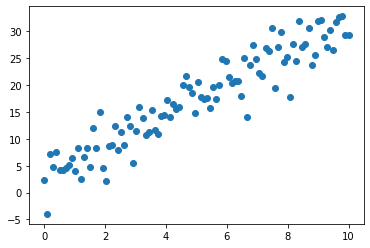

In [27]:
X = torch.linspace(0, 10, 100).unsqueeze(1)
Y = 2.5 + 3*X + 3*torch.randn(100,1)

fig = plt.figure()
plt.scatter(X, Y)
plt.show()

In [28]:
import torch.nn.functional as F 

# Complétez la définition de a, le coefficient directeur, et b, l'ordonnée à l'origine
a = Parameter(torch.randn(1,1), requires_grad=True)
b = Parameter(torch.randn(1,1), requires_grad=True)

# Complétez la définition de l'optimiseur : 
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html?highlight=sgd#torch.optim.SGD
optimizer = torch.optim.SGD(iter([a, b]), lr=1e-2)

for epoch in range(10):
    # Complétez le calcul de y_pred
    y_pred = torch.mm(X, a) + b 
    mse = F.mse_loss(Y, y_pred)
    mse.backward() # On calcule les gradients de mse par rapport à a et b 
    optimizer.step() # On met à jour les valeurs de a et b 
    optimizer.zero_grad() # On 'remet' les gradients à zéro pour la prochaine epoch 
    print(f'=== Epoch {epoch} ===  ')
    print(f'MSE: {mse.item():.3f}')
    

=== Epoch 0 ===  
MSE: 395.462
=== Epoch 1 ===  
MSE: 50.775
=== Epoch 2 ===  
MSE: 16.554
=== Epoch 3 ===  
MSE: 13.126
=== Epoch 4 ===  
MSE: 12.753
=== Epoch 5 ===  
MSE: 12.683
=== Epoch 6 ===  
MSE: 12.643
=== Epoch 7 ===  
MSE: 12.606
=== Epoch 8 ===  
MSE: 12.570
=== Epoch 9 ===  
MSE: 12.535


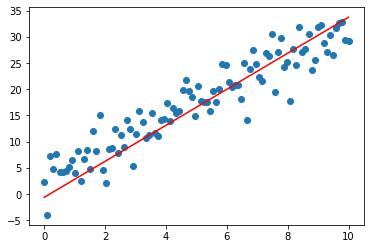

In [29]:
with torch.no_grad():
    y_pred = torch.mm(X, a) + b 
    
fig = plt.figure()
plt.scatter(X, Y)
plt.plot(X, y_pred, color='red')
plt.show()

### Les modèles

Les modèles sont les objets de PyTorch qui définissent les réseaux de neurones.

https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module

In [30]:
class LinearModel(torch.nn.Module):
    def __init__(self, x_dim):
        super(LinearModel, self).__init__()
        self.x_dim = x_dim
        self.linear = torch.nn.Linear(x_dim, 1)
        
    def forward(self, x):
        return self.linear(x)

In [31]:
linear_model = LinearModel(X.shape[1])
linear_model

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [32]:
for param in linear_model.named_parameters():
    print(param[0])

linear.weight
linear.bias


In [33]:
linear_model.linear.weight

Parameter containing:
tensor([[-0.8212]], requires_grad=True)

In [34]:
linear_model.linear.weight.shape

torch.Size([1, 1])

In [35]:
linear_model.linear.bias

Parameter containing:
tensor([0.7926], requires_grad=True)

In [36]:
optimizer = torch.optim.SGD(linear_model.parameters(), lr=1e-2)

for epoch in range(10):
    y_pred = linear_model(X)
    mse = F.mse_loss(Y, y_pred)
    mse.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f'=== Epoch {epoch} ===  ')
    print(f'MSE: {mse.item():.3f}')

=== Epoch 0 ===  
MSE: 557.326
=== Epoch 1 ===  
MSE: 64.027
=== Epoch 2 ===  
MSE: 15.095
=== Epoch 3 ===  
MSE: 10.235
=== Epoch 4 ===  
MSE: 9.747
=== Epoch 5 ===  
MSE: 9.692
=== Epoch 6 ===  
MSE: 9.680
=== Epoch 7 ===  
MSE: 9.673
=== Epoch 8 ===  
MSE: 9.666
=== Epoch 9 ===  
MSE: 9.659


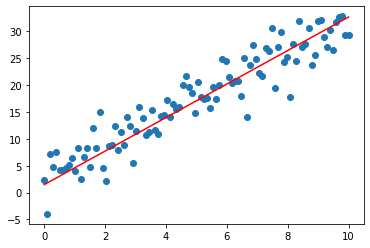

In [37]:
with torch.no_grad():
    y_pred = linear_model.forward(X)
    
fig = plt.figure()
plt.scatter(X, Y)
plt.plot(X, y_pred, color='red')
plt.show()

### Data Loaders

Les data loader sont des objets de PyTorch pour charger les données de manière à faciliter l'optimisation par "Batch stochastic gradient descent".

https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader

In [38]:
X = torch.linspace(0, 10, 100).unsqueeze(1)
Y = 2.5 + 3*X + 3*torch.randn((100,1))

data = torch.utils.data.TensorDataset(X, Y)

In [39]:
data

In [40]:
len(data)

100

In [41]:
loader = torch.utils.data.DataLoader(data, batch_size=20, shuffle=True)

In [42]:
len(loader)

5

In [43]:
optimizer = torch.optim.SGD(linear_model.parameters(), lr=1e-2)

for epoch in range(10):
    for batch, y in loader:
        y_pred = linear_model(batch)
        mse = F.mse_loss(y, y_pred)
        mse.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'=== Epoch {epoch} ===  ')
    print(f'MSE: {mse.item():.3f}')

=== Epoch 0 ===  
MSE: 6.037
=== Epoch 1 ===  
MSE: 4.272
=== Epoch 2 ===  
MSE: 7.355
=== Epoch 3 ===  
MSE: 6.146
=== Epoch 4 ===  
MSE: 9.837
=== Epoch 5 ===  
MSE: 9.229
=== Epoch 6 ===  
MSE: 5.367
=== Epoch 7 ===  
MSE: 7.894
=== Epoch 8 ===  
MSE: 7.093
=== Epoch 9 ===  
MSE: 9.756
